In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
# Make sure 'df_engineered.csv' is in the same directory as your notebook,
# or provide the full path to the file.
try:
    df = pd.read_csv('df_engineered.csv')
    print("Dataset loaded successfully.")
    print("Shape of the dataset:", df.shape)
except FileNotFoundError:
    print("Error: 'df_engineered.csv' not found. Please check the file path.")
    df = pd.DataFrame() # Create an empty DataFrame to prevent further errors if file not found

# Display basic info to confirm it's loaded (optional)
if not df.empty:
    print(df.head())
    # df.info() # You can uncomment this if you want to see the full info

Dataset loaded successfully.
Shape of the dataset: (7914, 65)
                             titulo     tipo_de_producto              serie  \
0     Apple MacBook Air 13" 2024 M3  Portátil multimedia  Apple MacBook Air   
1     Apple MacBook Air 15" 2024 M3  Portátil multimedia  Apple MacBook Air   
2   Apple MacBook Pro 14" M4 (2024)  Portátil multimedia  Apple MacBook Pro   
3  ASUS TUF Gaming A15 FA506 (2024)      Portátil gaming    ASUS TUF Gaming   
4         GigaByte Aero 16 OLED BKF      Portátil gaming      Gigabyte Aero   

  pantalla_tecnologia            procesador disco_duro_tipo_de_disco_duro  \
0              Retina              Apple M3                           SSD   
1              Retina              Apple M3                           SSD   
2              Retina               Unknown                           SSD   
3             Full HD               Unknown                           SSD   
4                UHD+  Intel Core i7-13700H                           SSD   



In [2]:
if not df.empty:
    # Define numerical and categorical columns (reusing the list from our previous work)
    numerical_cols = [
        'procesador_numero_nucleos', 'precio_mean', 'ram_memoria_gb',
        'disco_duro_capacidad_de_memoria_ssd_gb', 'procesador_frecuencia_turbo_max_ghz',
        'medidas_y_peso_profundidad_cm', 'medidas_y_peso_ancho_cm',
        'procesador_cache_mb', 'ram_frecuencia_de_la_memoria_mhz',
        'equip_altavoces_estéreo', 'equip_refrigeración_líquida', 'equip_usb_c'
    ]

    categorical_cols = [
        'tipo_de_producto', 'disco_duro_tipo_de_disco_duro', 'procesador_fabricante',
        'procesador_tipo', 'sistema_operativo_sistema_operativo', 'ram_tipo',
        'custom_category', 'comunicaciones_estandar_lan', 'tipo'
    ]

    # Create a new DataFrame with selected features
    features_df = df[numerical_cols + categorical_cols].copy()

    # Handle potential explicit NaN values in object columns if any before mode imputation
    for col in categorical_cols:
        if features_df[col].dtype == 'object':
            features_df[col] = features_df[col].fillna('Missing')

    # Create preprocessing pipelines
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Create a column transformer
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ], remainder='passthrough') # Using remainder='passthrough' just in case, though we selected all cols

    # Apply the preprocessing
    try:
        processed_features = preprocessor.fit_transform(features_df)
        print(f"Shape of processed features: {processed_features.shape}")
        # Optional: Get feature names after one-hot encoding for inspection
        # feature_names_out = preprocessor.get_feature_names_out()
        # processed_df_for_inspection = pd.DataFrame(processed_features, columns=feature_names_out)
        # print("\nFirst 5 rows of processed data (for inspection):")
        # print(processed_df_for_inspection.head())
    except Exception as e:
        print(f"An error occurred during preprocessing: {e}")
        processed_features = None # Set to None to prevent further errors

else:
    print("DataFrame is empty, skipping preprocessing.")
    processed_features = None

Shape of processed features: (7914, 157)


In [3]:
if processed_features is not None and not df.empty:
    chosen_k = 2
    print(f"Performing K-Means clustering with k={chosen_k}...")

    kmeans_k2 = KMeans(n_clusters=chosen_k, random_state=42, n_init='auto')
    cluster_labels_k2 = kmeans_k2.fit_predict(processed_features)

    # Add cluster labels to a copy of the original DataFrame
    df_clustered_k2 = df.copy()
    df_clustered_k2['cluster'] = cluster_labels_k2

    print(f"\nFirst 5 rows of the DataFrame with k={chosen_k} cluster labels:")
    print(df_clustered_k2[['titulo', 'tipo_de_producto', 'precio_mean', 'custom_category', 'cluster']].head())
else:
    print("Processed features not available or DataFrame empty, skipping K-Means clustering.")

Performing K-Means clustering with k=2...

First 5 rows of the DataFrame with k=2 cluster labels:
                             titulo     tipo_de_producto  precio_mean  \
0     Apple MacBook Air 13" 2024 M3  Portátil multimedia      1656.85   
1     Apple MacBook Air 15" 2024 M3  Portátil multimedia      1971.34   
2   Apple MacBook Pro 14" M4 (2024)  Portátil multimedia      3331.85   
3  ASUS TUF Gaming A15 FA506 (2024)      Portátil gaming       839.36   
4         GigaByte Aero 16 OLED BKF      Portátil gaming      1550.65   

  custom_category  cluster  
0          Laptop        0  
1          Laptop        0  
2          Laptop        0  
3          Laptop        0  
4          Laptop        0  


In [4]:
if processed_features is not None and 'df_clustered_k2' in locals():
    print(f"\nEvaluating clustering performance for k={chosen_k}...")

    silhouette_avg_k2 = silhouette_score(processed_features, cluster_labels_k2)
    calinski_harabasz_avg_k2 = calinski_harabasz_score(processed_features, cluster_labels_k2)
    davies_bouldin_avg_k2 = davies_bouldin_score(processed_features, cluster_labels_k2)

    print(f"\nPerformance Metrics for k={chosen_k}:")
    print(f"  Silhouette Score: {silhouette_avg_k2:.4f}")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz_avg_k2:.4f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_avg_k2:.4f}")

    print(f"\nCluster sizes (k={chosen_k}):")
    print(df_clustered_k2['cluster'].value_counts().sort_index())

    print(f"\nMean values of key numerical features for each cluster (k={chosen_k}):")
    key_numerical_for_analysis = ['precio_mean', 'ram_memoria_gb', 'disco_duro_capacidad_de_memoria_ssd_gb', 'procesador_numero_nucleos']
    cluster_summary_numerical_k2 = df_clustered_k2.groupby('cluster')[key_numerical_for_analysis].mean()
    print(cluster_summary_numerical_k2)

    print(f"\nMode of key categorical features for each cluster (k={chosen_k}):")
    key_categorical_for_analysis = ['custom_category', 'tipo_de_producto', 'procesador_fabricante']
    mode_agg = lambda x: x.mode()[0] if not x.mode().empty else 'N/A'
    cluster_summary_categorical_k2 = df_clustered_k2.groupby('cluster')[key_categorical_for_analysis].agg(mode_agg)
    print(cluster_summary_categorical_k2)
else:
    print("Clustering results not available for evaluation.")


Evaluating clustering performance for k=2...

Performance Metrics for k=2:
  Silhouette Score: 0.2959
  Calinski-Harabasz Index: 3172.0718
  Davies-Bouldin Index: 1.4422

Cluster sizes (k=2):
cluster
0    3917
1    3997
Name: count, dtype: int64

Mean values of key numerical features for each cluster (k=2):
         precio_mean  ram_memoria_gb  disco_duro_capacidad_de_memoria_ssd_gb  \
cluster                                                                        
0        1633.286533       17.524126                              639.869288   
1        1397.551078       21.210053                              879.552345   

         procesador_numero_nucleos  
cluster                             
0                        10.233852  
1                         9.711534  

Mode of key categorical features for each cluster (k=2):
        custom_category     tipo_de_producto procesador_fabricante
cluster                                                           
0                Laptop  Port

In [5]:
if processed_features is not None:
    print("\nPerforming PCA for visualization (reducing to 2 components)...")
    pca_visual = PCA(n_components=2, random_state=42)
    processed_features_pca_visual = pca_visual.fit_transform(processed_features)

    df_pca_k2 = pd.DataFrame(data=processed_features_pca_visual, columns=['PC1', 'PC2'])
    print(f"Shape of PCA-reduced data for visualization: {df_pca_k2.shape}")
    print(f"Total explained variance by 2 components: {pca_visual.explained_variance_ratio_.sum():.4f}")
else:
    print("Processed features not available, skipping PCA.")
    df_pca_k2 = None # Initialize to prevent error in next cell if this fails


Performing PCA for visualization (reducing to 2 components)...
Shape of PCA-reduced data for visualization: (7914, 2)
Total explained variance by 2 components: 0.5048


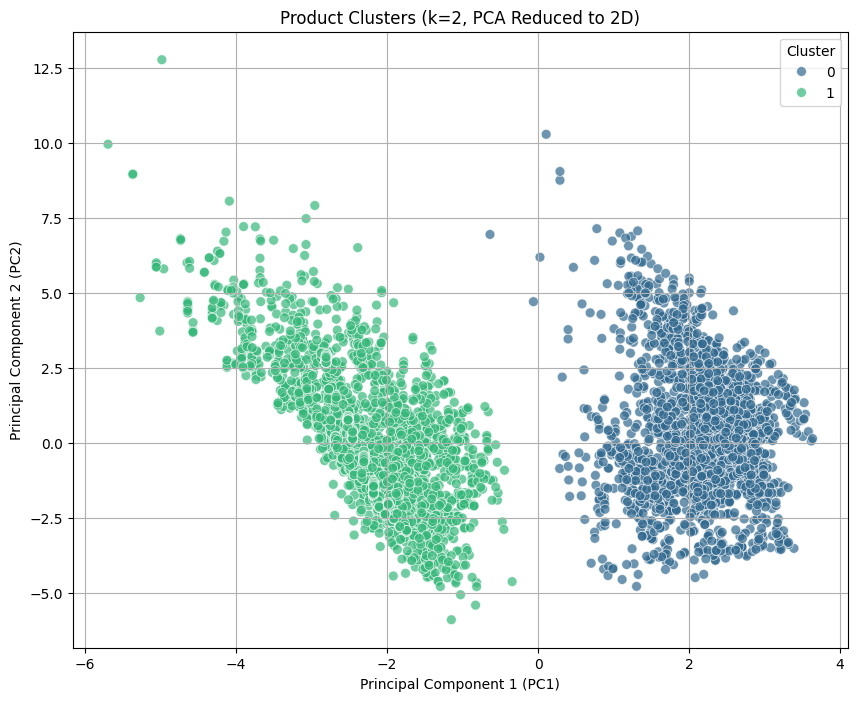

In [6]:
if df_pca_k2 is not None and 'cluster_labels_k2' in locals():
    df_pca_k2['cluster'] = cluster_labels_k2 # Add the k=2 cluster labels

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca_k2, palette='viridis', s=50, alpha=0.7)
    plt.title(f'Product Clusters (k={chosen_k}, PCA Reduced to 2D)')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()
else:
    print("PCA data or cluster labels not available for plotting by cluster.")


Number of unique 'tipo_de_producto' categories for PCA plot: 17


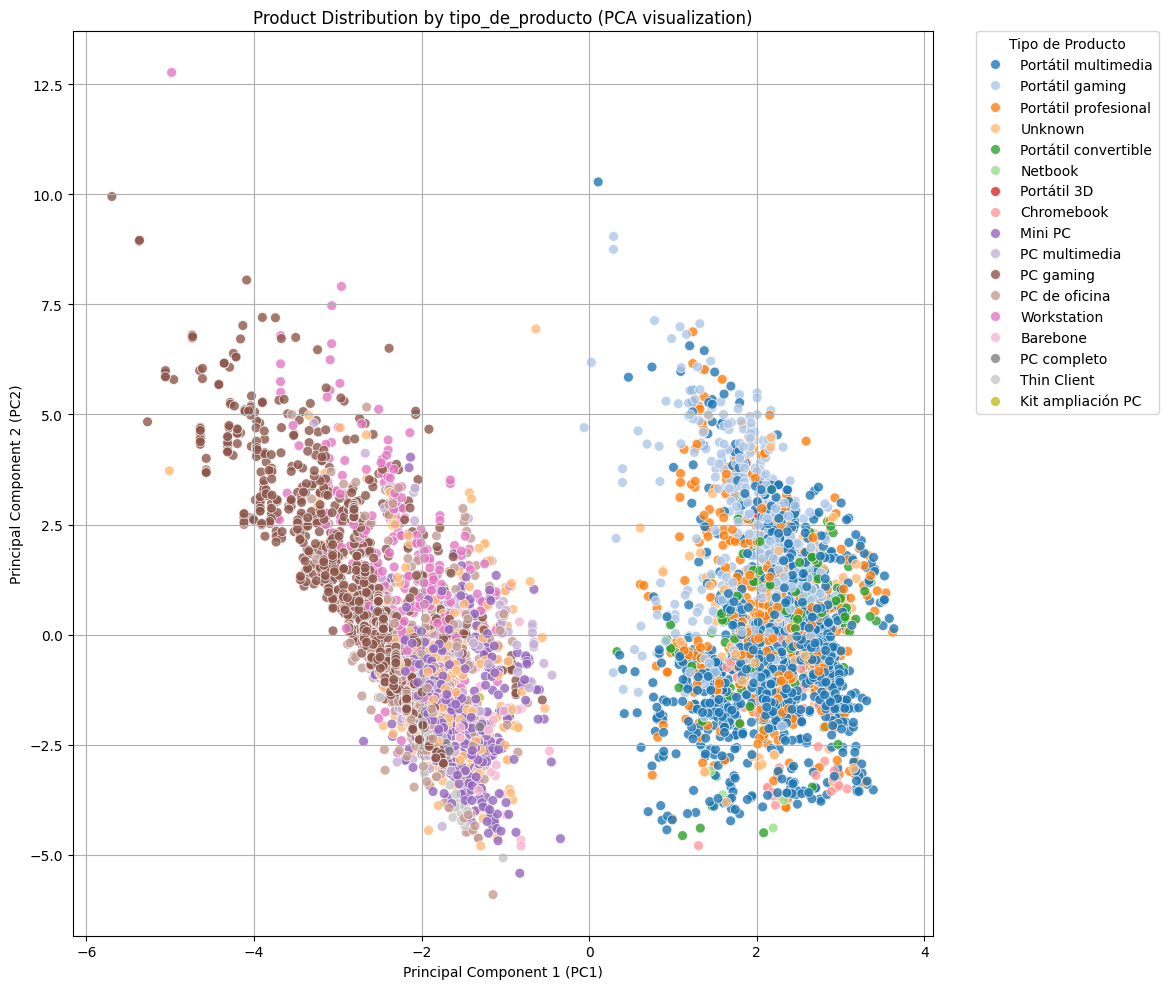

In [7]:
if df_pca_k2 is not None and 'df_clustered_k2' in locals():
    # Ensure 'cluster' column from previous plot doesn't interfere if we are re-adding columns for a new plot.
    # It's safer to take a fresh copy or select columns if df_pca_k2 is reused.
    # Here, we are just adding 'tipo_de_producto'.
    df_pca_k2['tipo_de_producto'] = df_clustered_k2['tipo_de_producto'].values

    unique_product_types_pca_k2 = df_pca_k2['tipo_de_producto'].nunique()
    print(f"\nNumber of unique 'tipo_de_producto' categories for PCA plot: {unique_product_types_pca_k2}")

    plt.figure(figsize=(14, 10))
    sns.scatterplot(
        x='PC1',
        y='PC2',
        hue='tipo_de_producto',
        data=df_pca_k2,
        palette='tab20' if unique_product_types_pca_k2 <= 20 else 'viridis',
        s=50,
        alpha=0.8,
        legend='auto'
    )
    plt.title('Product Distribution by tipo_de_producto (PCA visualization)')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')

    if unique_product_types_pca_k2 > 10:
        plt.legend(title='Tipo de Producto', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    else:
        plt.legend(title='Tipo de Producto')

    plt.grid(True)
    # Adjust layout if legend is outside
    plt.tight_layout(rect=[0, 0, 0.85, 1] if unique_product_types_pca_k2 > 10 else [0,0,1,1])
    plt.show()
else:
    print("PCA data or original clustered data not available for plotting by tipo_de_producto.")
